#### Bibliotecas

In [27]:
import pandas as pd
import sys
import warnings
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
from prince import MCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap 
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from ipywidgets import interact, Dropdown

In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### Importação e Limpeza Base de Dados

In [3]:
db = pd.read_csv('pesquisa-satisfacao-do-passageiro-2021-2023.csv', low_memory=False)

In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187322 entries, 0 to 187321
Data columns (total 96 columns):
 #   Column                                                              Non-Null Count   Dtype 
---  ------                                                              --------------   ----- 
 0   PROCESSO                                                            186712 non-null  object
 1   AEROPORTO                                                           186712 non-null  object
 2   DATA                                                                186712 non-null  object
 3   MÊS                                                                 186712 non-null  object
 4   INÍCIO COLETA                                                       186712 non-null  object
 5   FIM COLETA                                                          184274 non-null  object
 6   TERMINAL                                                            186710 non-null  object
 7   PORTÃO     

In [5]:
dados_faltantes_ = db.isna().sum() / len(db)
dados_faltantes_primeira_etapa = db.loc[:, dados_faltantes_ < 0.6]

In [6]:
dados_faltantes_primeira_etapa.drop(columns=['PROCESSO', 'INÍCIO COLETA', 'FIM COLETA', 'TERMINAL', 'PORTÃO','CONEXÃO', 'COMENTÁRIOS ADICIONAIS', 'VOO', 'NACIONALIDADE', 'MEIO DE  TRANSPORTE PARA O AEROPORTO'], inplace= True)

In [7]:
dados_n_faltantes = dados_faltantes_primeira_etapa
for atributo in dados_n_faltantes.columns:
    dados_n_faltantes = dados_n_faltantes.drop(dados_n_faltantes.loc[(dados_n_faltantes[atributo] == "NS") | 
                                                                    (dados_n_faltantes[atributo] == "NS/NR") | 
                                                                    (dados_n_faltantes[atributo] == "Não Informou") | 
                                                                    (dados_n_faltantes[atributo].isna())].index , axis=0)
    dados_n_faltantes.reset_index(drop=True, inplace=True)

#### Organização dos Dados

In [8]:
dados_n_faltantes = dados_n_faltantes.drop(dados_n_faltantes.loc[(dados_n_faltantes['TIPO DE VOO'] == 'Internacional')].index , axis=0)
dados_n_faltantes.reset_index(drop=True, inplace=True)

In [9]:
dados_n_faltantes.drop(columns=['TIPO DE VOO'], inplace= True)

In [10]:
datas_remover = ['44849','44851', '44852', '44853', '44854', '44855', '44856', '44858','44859', '44835', '44837', '44838', '44839', '44840', '44841', '44842', '44843', '44844', '44845', '44847', '44848', '44857', '44850', '44846']

dados_n_faltantes = dados_n_faltantes[~dados_n_faltantes['DATA'].isin(datas_remover)]

In [11]:
dados_n_faltantes['DATA'] = pd.to_datetime(dados_n_faltantes['DATA'], format='%d/%m/%Y').dt.year

In [12]:
dados_n_faltantes['CIA AÉREA'] = dados_n_faltantes["CIA AÉREA"].str.lower()
dados_n_faltantes['CIA AÉREA'] = dados_n_faltantes['CIA AÉREA'].replace('voopass', 'voepass')

In [13]:
dados_n_faltantes['POSSUI DEFICIÊNCIA'] = dados_n_faltantes['POSSUI DEFICIÊNCIA'].replace('Nenhuma.', 'Nenhuma')

In [14]:
dados_n_faltantes.loc[dados_n_faltantes['POSSUI DEFICIÊNCIA'] != 'Nenhuma','POSSUI DEFICIÊNCIA'] = 'Possui'

In [15]:
dados_n_faltantes['SANITÁRIOS'] = dados_n_faltantes["SANITÁRIOS"].map(lambda x: int(float(x)))

In [16]:
dados_n_faltantes['IDADE'] = dados_n_faltantes['IDADE'].replace('56 a 64 anos', '56 a 65 anos')

In [17]:
dados_n_faltantes['RENDA FAMILIAR'] = dados_n_faltantes["RENDA FAMILIAR"].str.lower()
dados_n_faltantes['RENDA FAMILIAR'] = dados_n_faltantes["RENDA FAMILIAR"].str.replace('.', '', regex=False)

In [18]:
dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].str.lower()
dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('1 (primeira viagem)', 'Primeira')
dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = dados_n_faltantes['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('1 - primeira viagem', 'Primeira')

In [19]:
mapeamento_motivo = {'Trabalho': 1, 
                     'Lazer': 2, 
                     'Outros': 3, 
                     'Lazer e Trabalho': 4,
                     'Visitar a irmã doente': 5, 
                     'Entrevista p visto amaricano': 6, 
                     'Saúde': 7,
                     'Qualificação': 8, 
                     'Estudos': 8, 
                     'Visitar familiares': 5,
                     'Voltando para casa': 6, 
                     'Mudança': 6, 
                     'Estudo, curso': 8, 
                     'Estudo': 8,
                     'Morar em outro estado': 6, 
                     'Tratamento médico': 7, 
                     'Visitar família': 5,
                     'Retorno para casa': 6, 
                     'Férias': 2, 
                     'Vista a familiares': 5, 
                     'Evento': 2,
                     'Competição': 8, 
                     'Medico': 7, 
                     'Midança de pais': 6, 
                     'Regresso a casa': 6,
                     'Cuidar da filha': 5, 
                     'Voltando pra casa depois do passeio': 6,
                     'Vizitar familiar': 5, 
                     'Curso': 8,
                     'Visita médica a sobrinha no hospital': 5, 
                     'Família': 5,
                     'NR passageiro teve que embarcar': 3, 
                     'Voltando pra casa': 6, 
                     'Saude': 7,
                     'Visitar família,pai doente': 5, 
                     'Visitar parentes': 5, 
                     'Ver o namorado': 5,
                     'Congresso.': 8, 
                     'Show': 2, 
                     'Esta indo para um seminário': 8, 
                     'Prova': 8,
                     'Fazer Prova': 8, 
                     'Concurso': 8, 
                     'Luto': 5, 
                     'Mora. Fora': 6,
                     'Prestar concurso': 8, 
                     'Visitar parentes família': 5,
                     'Visitar a família': 5, 
                     'Congresso': 8, 
                     'Folga': 2, 
                     'Ver a mae': 5,
                     'Visita a familia': 5, 
                     'Fazer visto americano': 6, 
                     'Passeio': 2,
                     'Tratamento de saúde': 7, 
                     'Cuidar do filho internado': 5,
                     'Evento acadêmico': 8, 
                     'Visto': 6, 
                     'Estudando': 8,
                     'Acompanhar o filho no futebol': 5, 
                     'Turismo e visita': 2,
                     'Renovar o visto': 6, 
                     'mudança': 6, 
                     'Doença': 7, 
                     'Volta para casa': 6,
                     'Estudo.': 8, 
                     'Estao de mudança': 6, 
                     'Turismo': 2, 
                     'Visto americano': 6,
                     'Convenção': 8, 
                     'Regresso para casa': 6, 
                     'Familia': 5, 
                     'Fazer Sport': 8,
                     'Assuntos pessoais': 5, 
                     'Compromissos': 5, 
                     'Retorno ao domicílio': 6,
                     'Encontro da igreja': 8, 
                     'Concurso publico': 8, 
                     'Particular': 5,
                     'Falecimento familiar': 5, 
                     'Falecimento de família': 5, 
                     'Volta pra casa': 6,
                     'Entrevista de visto': 6, 
                     'Rotina, visitar família': 5,
                     'Visita familiares': 5, 
                     'Lua de mel': 5, 
                     'Motivo de saúde': 7,
                     'Mora no exterior': 6, 
                     'Aniversário da mãe': 5, 
                     'Visitar familia': 5,
                     'Pessoal': 5, 
                     'Visita familiar': 5, 
                     'Visita famíliar': 5,
                     'Retorno de férias': 2, 
                     'Óbito': 5, 
                     'Conhecer neta': 5,
                     'Visita saúde família': 5, 
                     'Doença familiar': 5, 
                     'Turismo religioso': 8,
                     'Saúde e mudança': 7, 
                     'Visitar os país': 5, 
                     'Descanso': 2,
                     'tratamento médico': 7, 
                     'Estudante': 8,
                     'Vim renovar visto e estou retornando para casa': 6, 
                     'Cidadania': 6,
                     'Morte de um ente querido': 5, 
                     'Estudar': 7, 
                     'Curso de formação': 8,
                     'Retornado pra casa': 6, 
                     'Familiar': 5, 
                     'Consulta médica': 7,
                     'Visitar os filhos': 5, 
                     'Retiro espiritual': 8,
                     'Visitar família, voltando pra casa': 5, 
                     'Emergência': 5,
                     'retornando pra casa': 6, 
                     'Fzer visto americano': 6, 
                     'Doença na família': 5,
                     'Turismo e consulta médica': 2, 
                     'Aniversário': 5, 
                     'Congresso e feira': 8,
                     'Aniversário sobrinha neta': 5,
                     'Voltar para casa, estava aqui a passeio': 2, 
                     'Concurso público': 8,
                     'morte': 5, 
                     'Intercambio fora do Brasil': 8, 
                     'Pessoais': 5,
                     'visitar família': 5, 
                     'Pwgar visto americano': 6,
                     'Falwcimento de um parente': 5,
                     'Esporte': 8, 
                     'Emergencia': 5,
                     'Retornando para casa': 6, 
                     'Retornar para a casa, na Inglaterra.': 6,
                     'Consulta médica/cirurgia': 7, 
                     'Congresso religioso': 8,
                     'Voltando pra casa, veio visitar a família': 6,
                     'Evento na família, casamento': 5, 
                     'Casamento': 5,
                     'Cuidar pais idosos': 5,
                     'Familar': 5, 
                     'Seminário': 8, 
                     'Evento/convenção': 8, 
                     'Questão familiar': 5,
                     'Moradia': 6, 
                     'Receber apartamento': 3, 
                     'Falecimento': 5, 
                     'Missão': 8,
                     'Visto americano em Brasília': 6, 
                     'Ver familia': 5, 
                     'Mudando': 6, 
                     'Visita': 5,
                     'Negocio': 1, 
                     'Negócio': 1, 
                     'Visita a pessoa doente': 5, 
                     'Óbito familiar': 5,
                     'Mudança moradia': 6, 
                     'Veio fazer concurso': 8, 
                     'Morte família': 5,
                     'Tirar visto, agora retorno para casa': 6, 
                     'Problema familiar': 5,
                     'Casamento de amiga': 5, 
                     'Pós graduação': 8, 
                     'Retorno a casa': 6,
                     'Campeonato': 8, 
                     'vai cuidar da saúde da mãe': 5,
                     'Veio tirar o visto, retornando pra casa': 6, 
                     'Recreio': 2, 
                     'Ferias': 2,
                     'Visita a família': 5, 
                     'luto': 5,
                     'Treinamento de qualificação pela empresa': 1, 
                     'Retornando pra casa': 6,
                     'Compromisso na embaixada': 3, 
                     'Mora em Portugal': 6, 
                     'Ir a embaixada': 3,
                     'Retorno pra casa': 6, 
                     'Família,': 5, 
                     'Visita ao Filho': 5,
                     'Saúde e trabalho': 7, 
                     'Trabalho e estudo': 1, 
                     'Acadêmico/Concurso': 8,
                     'Funeral/Óbito': 5, 
                     'Retornando para Casa': 6,
                     'Congresso/Seminário/Palestra': 8, 
                     'lazer': 2, 
                     'Retiro': 8,
                     'Estudos/Congressos/Seminários/Palestras': 8,
                     'Saúde/Tratamento/Consulta/Exames': 7, 
                     'Jurídico/Embaixada': 3,
                     'Esporte/Campeonato/Competição': 8, 
                     'Familiar / Família': 5}
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].map(mapeamento_motivo)

In [20]:
dados_n_faltantes = dados_n_faltantes.drop(dados_n_faltantes.loc[(dados_n_faltantes['MOTIVO DA VIAGEM'].isna())].index , axis=0)
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].astype(int)
dados_n_faltantes.reset_index(drop=True, inplace=True)

In [21]:
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(1, 'Trabalho')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(2, 'Lazer')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(3, 'Outros')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(4, 'Lazer e Trabalho')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(5, 'Familia')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(6, 'Mudança')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(7, 'Saude')
dados_n_faltantes['MOTIVO DA VIAGEM'] = dados_n_faltantes['MOTIVO DA VIAGEM'].replace(8, 'Esutdo')

In [23]:
colunas_teste = ['FACILIDADE DE DESEMBARQUE NO MEIO-FIO', 'PROCESSO DE INSPEÇÃO DE SEGURANÇA', 'LOCALIZAÇÃO E DESLOCAMENTO', 'CONFORTO DA SALA DE EMBARQUE', 
                 'DISPONIBILIDADE DE TOMADAS','SANITÁRIOS', 'LIMPEZA GERAL DO AEROPORTO', 'SATISFAÇÃO GERAL', 'IDADE', 'ESCOLARIDADE', 'RENDA FAMILIAR', 'QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES', 'ANTECEDÊNCIA']

In [37]:
db_v1 = dados_n_faltantes[colunas_teste]

#### Análise do Banco de Dados Limpo

In [38]:
columns_to_plot = [
    'FACILIDADE DE DESEMBARQUE NO MEIO-FIO', 'PROCESSO DE INSPEÇÃO DE SEGURANÇA', 
    'LOCALIZAÇÃO E DESLOCAMENTO', 'CONFORTO DA SALA DE EMBARQUE', 
    'DISPONIBILIDADE DE TOMADAS', 'SANITÁRIOS', 'LIMPEZA GERAL DO AEROPORTO', 
    'SATISFAÇÃO GERAL', 'IDADE', 'ESCOLARIDADE', 'RENDA FAMILIAR', 
    'QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES', 'ANTECEDÊNCIA'
]

def plot_bar(column):
    """Função para plotar gráfico de barras de uma coluna específica."""
    values = db_v1[column].value_counts(normalize=True).sort_index()
    basic_colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']
    colors = basic_colors[:len(values)]
    
    plt.figure(figsize=(10, 6))
    values.plot(kind='bar', color=colors, edgecolor='black')
    plt.title(f'Distribuição de {column}')
    plt.ylabel('Proporção')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Dropdown para selecionar as colunas
dropdown = Dropdown(
    options=columns_to_plot,
    description='Coluna:',
    style={'description_width': 'initial'}
)

# Interatividade
interact(plot_bar, column=dropdown)

interactive(children=(Dropdown(description='Coluna:', options=('FACILIDADE DE DESEMBARQUE NO MEIO-FIO', 'PROCE…

<function __main__.plot_bar(column)>

#### Normalização

In [43]:
db_v1['IDADE'] = db_v1['IDADE'].replace('18 a 25 anos', 1)
db_v1['IDADE'] = db_v1['IDADE'].replace('26 a 35 anos', 2)
db_v1['IDADE'] = db_v1['IDADE'].replace('36 a 45 anos', 3)
db_v1['IDADE'] = db_v1['IDADE'].replace('46 a 55 anos', 4)
db_v1['IDADE'] = db_v1['IDADE'].replace('56 a 65 anos', 5)
db_v1['IDADE'] = db_v1['IDADE'].replace('Mais de 65 anos', 6)

In [45]:
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Analfabeto', 1)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Ensino fundamental', 2)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Ensino médio', 3)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Superior', 4)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Especialização de nível superior', 5)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Mestrado', 5)
db_v1['ESCOLARIDADE'] = db_v1['ESCOLARIDADE'].replace('Doutorado', 7)

In [46]:
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('outros', 1)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('prefiro não informar', 2)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('até 1 salário mínimo', 3)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('entre 1 e 2 sm', 4)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('entre 2 e 4 sm', 5)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('entre 4 e 10 sm', 6)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('entre 10 e 20 sm', 7)
db_v1['RENDA FAMILIAR'] = db_v1['RENDA FAMILIAR'].replace('mais de 20 sm', 8)

In [47]:
db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('Primeira', 1)
db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('2 a 3', 2)
db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('4 a 5', 3)
db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('6 a 10', 4)
db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'] = db_v1['QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES'].replace('mais de 11', 5)

In [48]:
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('30min a 1h', 1)
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('1h a 1h30min', 2)
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('1h30min a 2h', 3)
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('2h a 2h30min', 4)
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('2h30min a 3h', 5)
db_v1['ANTECEDÊNCIA'] = db_v1['ANTECEDÊNCIA'].replace('Mais de 3h', 6)

In [49]:
df_test = db_v1

In [51]:
scaler = MinMaxScaler()

In [52]:
dados_normalizados = scaler.fit_transform(df_test)

In [53]:
dados_normalizados_bd = pd.DataFrame(dados_normalizados, columns=df_test.columns)

#### Kmeans, Kmodes, DBscan, Método Hierárquico

##### Kmodes

In [54]:
costs = []
k_max = 5

In [55]:
for k in range(1, k_max + 1):
    kmodes = KModes(n_clusters=k, init= 'Huang',random_state=42)
    kmodes.fit(dados_normalizados)
    costs.append(kmodes.cost_)

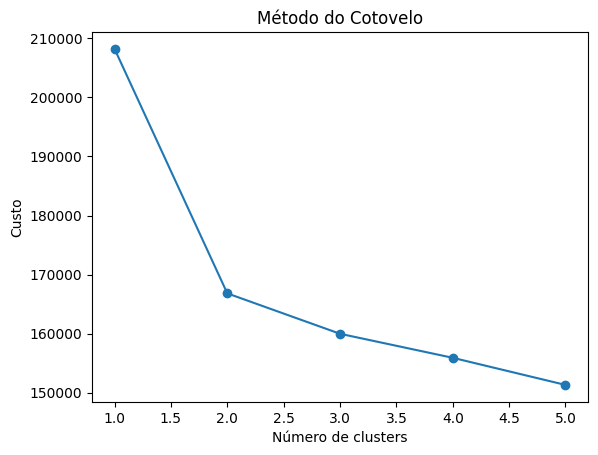

In [56]:
plt.plot(range(1, k_max + 1), costs, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Custo')
plt.title('Método do Cotovelo')
plt.show()

In [57]:
silhouette_scores_pca = []
silhouette_scores = []
k_max_s = 5


In [58]:
for k in range(2, k_max_s + 1):
    kmodes = KModes(n_clusters=k, init= 'Huang' ,random_state=42)
    cluster_labels = kmodes.fit_predict(dados_normalizados)
    silhouette_avg = silhouette_score(dados_normalizados, cluster_labels)
    silhouette_scores.append({'Número de Clusters': k, 'Silhouette Score': silhouette_avg})


In [59]:
resultados_df = pd.DataFrame(silhouette_scores)
resultados_df.sort_values(by='Silhouette Score', ascending=False, inplace=True)
resultados_df.reset_index(inplace=True, drop=True)


In [60]:
resultados_df

,Número de Clusters,Silhouette Score
0,2,0.104220
1,3,0.023203
2,4,0.010360
3,5,0.006049


##### KMeans

In [62]:
silhouette_scores_km = []
k_max_s = 10

In [63]:
for k in range(2, k_max_s + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(dados_normalizados)
    silhouette_avg = silhouette_score(dados_normalizados, cluster_labels)
    silhouette_scores_km.append({'Número de Clusters': k, 'Silhouette Score': silhouette_avg})

In [64]:
resultados_df_km = pd.DataFrame(silhouette_scores_km)
resultados_df_km.sort_values(by='Silhouette Score', ascending=False, inplace=True)
resultados_df_km.reset_index(inplace=True, drop=True)


In [65]:
resultados_df_km

,Número de Clusters,Silhouette Score
0,2,0.166498
1,3,0.119718
2,4,0.117228
3,5,0.115160
4,6,0.107981
5,7,0.102971
6,8,0.100476
7,10,0.097648
8,9,0.094171


In [66]:
soma_quadrados_distancias = []

In [67]:
for k in range(1, k_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dados_normalizados)
    soma_quadrados_distancias.append(kmeans.inertia_)

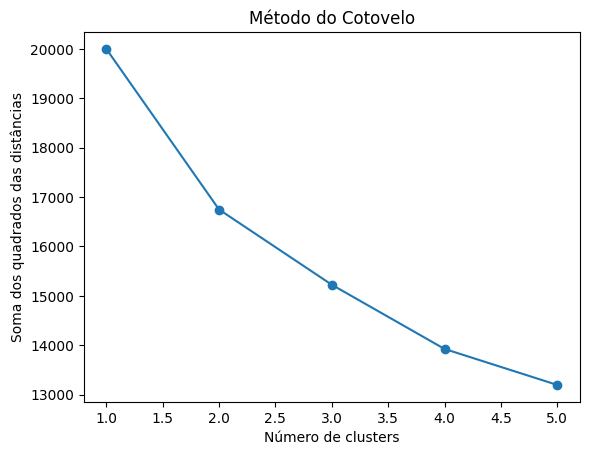

In [68]:
plt.plot(range(1, k_max + 1), soma_quadrados_distancias, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Soma dos quadrados das distâncias')
plt.title('Método do Cotovelo')
plt.show()

##### DBSCAN

In [69]:
eps_values = [0.5 + 0.1 * i for i in range(1, 15)]  
min_samples = 5 

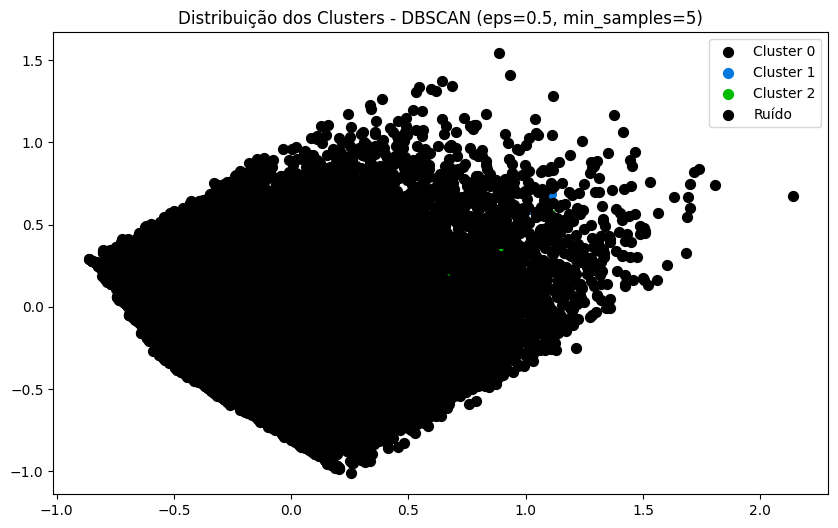

In [70]:
eps = 0.5  # Ajuste conforme necessário
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(dados_normalizados_bd)

# Reduzindo os dados para 2D com PCA para visualização (caso sejam multidimensionais)
pca = PCA(n_components=2)
dados_2d = pca.fit_transform(dados_normalizados_bd)

# Plotando os clusters
plt.figure(figsize=(10, 6))
unique_labels = set(cluster_labels)

for label in unique_labels:
    cor = 'k' if label == -1 else plt.cm.nipy_spectral(float(label) / len(unique_labels))  # Ruído em preto
    plt.scatter(
        dados_2d[cluster_labels == label, 0], 
        dados_2d[cluster_labels == label, 1], 
        s=50, c=[cor], label=f'Cluster {label}' if label != -1 else 'Ruído'
    )

plt.title(f'Distribuição dos Clusters - DBSCAN (eps={eps}, min_samples={min_samples})')
plt.legend(loc='best')
plt.show()

##### Método Hierárquico

In [71]:
n_clusters_values = range(2, 11)  # Testa de 2 a 10 clusters

# Loop para testar diferentes números de clusters e calcular o Silhouette Score
for n_clusters in n_clusters_values:
    hierarquico = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hierarquico.fit_predict(dados_normalizados_bd)

    # Calcula o Silhouette Score para cada configuração
    silhouette_avg = silhouette_score(dados_normalizados_bd, cluster_labels)
    print(f"Número de Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

Número de Clusters: 2, Silhouette Score: 0.1323
Número de Clusters: 3, Silhouette Score: 0.0879
Número de Clusters: 4, Silhouette Score: 0.0557
Número de Clusters: 5, Silhouette Score: 0.0648
Número de Clusters: 6, Silhouette Score: 0.0374
Número de Clusters: 7, Silhouette Score: 0.0324
Número de Clusters: 8, Silhouette Score: 0.0382
Número de Clusters: 9, Silhouette Score: 0.0428
Número de Clusters: 10, Silhouette Score: 0.0496


#### PCA e MCA

##### PCA KMeans

In [72]:
k_pca = [2,3,4,5]

for kpca in k_pca:
    pca = PCA(n_components=kpca)
    pca_result = pca.fit_transform(dados_normalizados)


    silhouette_scores_pca = []
    for k in range(2, k_max_s + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels_pca = kmeans.fit_predict(pca_result)
        silhouette_avg_pca = silhouette_score(pca_result, cluster_labels_pca)
        silhouette_scores_pca.append({'Número de Clusters': k, 'Silhouette Score': silhouette_avg_pca})
    resultados_pca = pd.DataFrame(silhouette_scores_pca)
    resultados_pca.sort_values(by='Silhouette Score', ascending=False, inplace=True)
    resultados_pca.reset_index(inplace=True, drop=True)
    print(f'Número de componentes pca = {kpca}')
    print(resultados_pca)
    print('--------------------------------------------------------------------------')

Número de componentes pca = 2
   Número de Clusters  Silhouette Score
0                   2          0.368817
1                   3          0.361645
2                   4          0.361431
3                   7          0.341061
4                   6          0.340066
5                   9          0.339304
6                   8          0.338968
7                   5          0.334203
8                  10          0.332463
--------------------------------------------------------------------------
Número de componentes pca = 3
   Número de Clusters  Silhouette Score
0                   2          0.282971
1                   7          0.276017
2                   8          0.275221
3                   3          0.274333
4                   5          0.270582
5                  10          0.269600
6                   4          0.269039
7                   6          0.267468
8                   9          0.263403
-----------------------------------------------------------------

##### PCA KModes

In [73]:
k_pca = [2,3,]
k_max_sp = 5

for kpca in k_pca:
    pca = PCA(n_components=kpca)
    pca_result = pca.fit_transform(dados_normalizados)


    silhouette_scores_pca = []
    for k in range(2, k_max_sp + 1):
        kmodes = KModes(n_clusters=k, init= 'Huang' ,random_state=42)
        cluster_labels_pca = kmodes.fit_predict(pca_result)
        silhouette_avg_pca = silhouette_score(pca_result, cluster_labels_pca)
        silhouette_scores_pca.append({'Número de Clusters': k, 'Silhouette Score': silhouette_avg_pca})
    resultados_pca = pd.DataFrame(silhouette_scores_pca)
    resultados_pca.sort_values(by='Silhouette Score', ascending=False, inplace=True)
    resultados_pca.reset_index(inplace=True, drop=True)
    print(f'Número de componentes pca = {kpca}')
    print(resultados_pca)
    print('--------------------------------------------------------------------------')

Número de componentes pca = 2
   Número de Clusters  Silhouette Score
0                   2          0.195095
1                   3         -0.230716
2                   4         -0.270616
3                   5         -0.468510
--------------------------------------------------------------------------
Número de componentes pca = 3
   Número de Clusters  Silhouette Score
0                   2          0.114391
1                   4         -0.236818
2                   3         -0.280597
3                   5         -0.438068
--------------------------------------------------------------------------


##### PCA Método Hierárquico

In [74]:
pca = PCA(n_components=2)
dados_2d = pca.fit_transform(dados_normalizados_bd)

# Lista de valores de clusters a serem testados
n_clusters_values = range(2, 11)  # Testa de 2 a 10 clusters

# Loop para testar diferentes números de clusters e calcular o Silhouette Score
for n_clusters in n_clusters_values:
    hierarquico = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hierarquico.fit_predict(dados_2d)

    # Calcula o Silhouette Score para cada configuração
    silhouette_avg = silhouette_score(dados_2d, cluster_labels)
    print(f"Número de Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

Número de Clusters: 2, Silhouette Score: 0.3548
Número de Clusters: 3, Silhouette Score: 0.2920
Número de Clusters: 4, Silhouette Score: 0.2852
Número de Clusters: 5, Silhouette Score: 0.2756
Número de Clusters: 6, Silhouette Score: 0.2732
Número de Clusters: 7, Silhouette Score: 0.2835
Número de Clusters: 8, Silhouette Score: 0.2837
Número de Clusters: 9, Silhouette Score: 0.2838
Número de Clusters: 10, Silhouette Score: 0.2675


##### MCA KMeans

In [76]:
mca =MCA(n_components = 2, n_iter = 10, random_state = 42)
mca.fit(dados_normalizados_bd)
mpg_mca = mca.transform(dados_normalizados_bd)

In [77]:
kmeans_mc = KMeans(n_clusters=2,random_state=42)
cluster_labels_mca_km = kmeans_mc.fit_predict(mpg_mca)
silhouette_avg_mca_km = silhouette_score(mpg_mca, cluster_labels_mca_km)
print(silhouette_avg_mca_km)

0.4792888676792074


Número de Clusters: 2, Silhouette Score: 0.4793
Número de Clusters: 3, Silhouette Score: 0.5146
Número de Clusters: 4, Silhouette Score: 0.4335
Número de Clusters: 5, Silhouette Score: 0.4401
Número de Clusters: 6, Silhouette Score: 0.4390
Número de Clusters: 7, Silhouette Score: 0.3798
Número de Clusters: 8, Silhouette Score: 0.3982
Número de Clusters: 9, Silhouette Score: 0.3937
Número de Clusters: 10, Silhouette Score: 0.3566


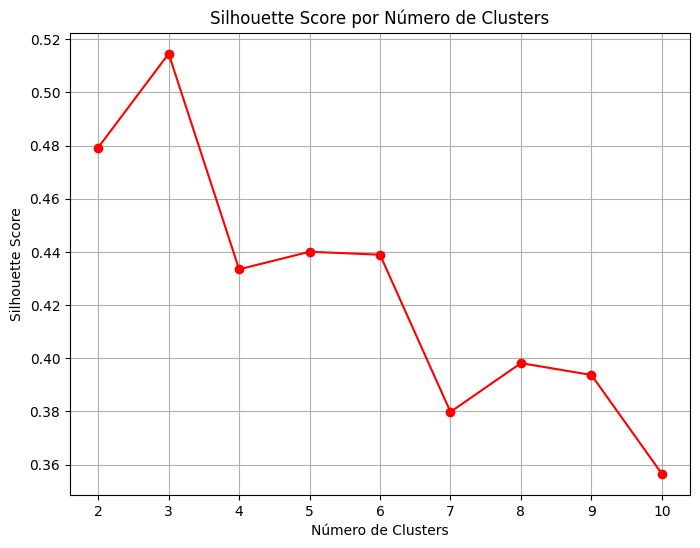

In [79]:
# Lista de valores de clusters a serem testados
n_clusters_values = range(2, 11)  # Testa entre 2 e 10 clusters

# Lista para armazenar os Silhouette Scores
silhouette_scores_mca = []

# Loop para calcular o Silhouette Score para cada número de clusters
for n_clusters in n_clusters_values:
    kmeans_mc = KMeans(n_clusters=n_clusters,random_state=42)
    cluster_labels_km = kmeans_mc.fit_predict(mpg_mca)

    # Calculando e armazenando o Silhouette Score
    score_km = silhouette_score(mpg_mca, cluster_labels_km)
    silhouette_scores_mca.append(score_km)
    print(f"Número de Clusters: {n_clusters}, Silhouette Score: {score_km:.4f}")

# Plotando o gráfico do Silhouette Score por número de clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_values, silhouette_scores_mca, marker='o', linestyle='-', color='r')
plt.title('Silhouette Score por Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

##### MCA Método Hierárquico

Número de Clusters: 2, Silhouette Score: 0.4475
Número de Clusters: 3, Silhouette Score: 0.4428
Número de Clusters: 4, Silhouette Score: 0.4483
Número de Clusters: 5, Silhouette Score: 0.3613
Número de Clusters: 6, Silhouette Score: 0.3498
Número de Clusters: 7, Silhouette Score: 0.3599
Número de Clusters: 8, Silhouette Score: 0.3683
Número de Clusters: 9, Silhouette Score: 0.3386
Número de Clusters: 10, Silhouette Score: 0.3354


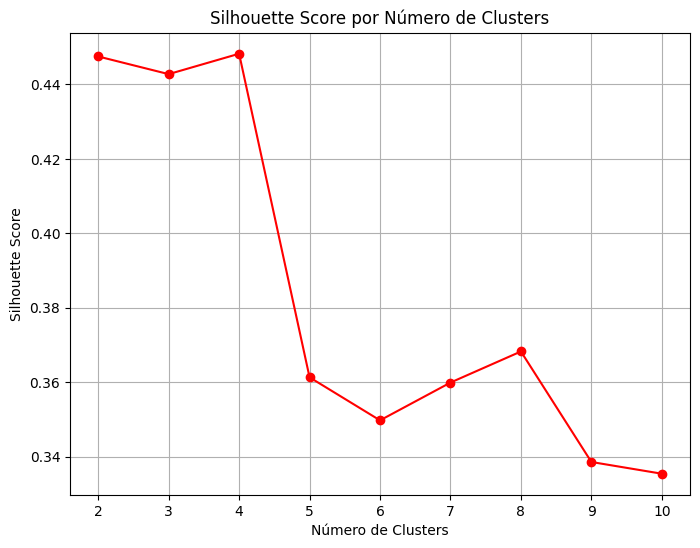

In [80]:
mca = MCA(n_components=2, n_iter=10, random_state=42)
mca.fit(dados_normalizados_bd)
dados_2d_mca = mca.transform(dados_normalizados_bd)

# Lista de valores de clusters a serem testados
n_clusters_values = range(2, 11)  # Testa entre 2 e 10 clusters

# Lista para armazenar os Silhouette Scores
silhouette_scores_mca = []

# Loop para calcular o Silhouette Score para cada número de clusters
for n_clusters in n_clusters_values:
    hierarquico = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hierarquico.fit_predict(dados_2d_mca)

    # Calculando e armazenando o Silhouette Score
    score = silhouette_score(dados_2d_mca, cluster_labels)
    silhouette_scores_mca.append(score)
    print(f"Número de Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

# Plotando o gráfico do Silhouette Score por número de clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_values, silhouette_scores_mca, marker='o', linestyle='-', color='r')
plt.title('Silhouette Score por Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

#### Clusterização

In [84]:
mca = MCA(n_components=2, n_iter=10, random_state=42)
mca_n_coluna = mca.fit_transform(dados_normalizados_bd)
kmeans = KMeans(n_clusters=3, random_state=42)
hierarquico = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_2_ac_mca = hierarquico.fit_predict(mca_n_coluna)
cluster_3_km_mca = kmeans.fit_predict(mca_n_coluna)

In [83]:
db_cl = dados_n_faltantes

In [90]:
dados_class = dados_normalizados_bd

In [91]:
db_cl['KM_MCA_3'] = cluster_3_km_mca
db_cl['AM_MCA_2'] = cluster_2_ac_mca

In [92]:
db_class_km = dados_normalizados_bd
db_class_am = dados_normalizados_bd

In [93]:
db_class_km['KM_MCA_3'] = cluster_3_km_mca
db_class_am['AM_MCA_2'] = cluster_2_ac_mca

#### Análise Gráfica Clusters

In [97]:
def plot_cluster_distribution(cluster_column, data_column):
    # Verifica se as colunas existem no DataFrame
    if cluster_column not in db_cl.columns or data_column not in db_cl.columns:
        print(f"Uma das colunas '{cluster_column}' ou '{data_column}' não existe no DataFrame!")
        return
    
    # Agrupar e contar ocorrências
    count_data = db_cl.groupby([data_column, cluster_column]).size().reset_index(name='count')
    
    # Transformar em pivot table
    # Linhas: valores de data_column
    # Colunas: clusters
    # Valores: contagem
    pivot_df = count_data.pivot(index=data_column, columns=cluster_column, values='count').fillna(0)
    
    # Ordenar o índice se for numérico, para evitar eixos bagunçados
    try:
        pivot_df.index = pivot_df.index.astype(int)  # tenta converter para int
        pivot_df.sort_index(inplace=True)
    except:
        # Se não for numérico, não faz nada
        pass

    # Cria figura e subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharex=False)
    
    # --------------------------
    # 1) GRÁFICO DE LINHAS (ABSOLUTO)
    # --------------------------
    # Escolhe uma paleta de cores mais vibrantes
    colors = sns.color_palette('bright', n_colors=len(pivot_df.columns))
    
    # Plotar cada cluster como uma linha
    for (cluster_id, color) in zip(pivot_df.columns, colors):
        ax1.plot(
            pivot_df.index,        # eixo X
            pivot_df[cluster_id],  # eixo Y
            marker='o',
            linestyle='-',
            label=f'Cluster {cluster_id}',
            color=color
        )
    
    # Configurações do eixo X para remover fracionários (se for numérico)
    # Vamos mostrar somente cada valor único presente em pivot_df.index
    # Se o índice for numérico inteiro, isso impede valores como 1.5, 2.5, etc.
    if pd.api.types.is_numeric_dtype(pivot_df.index):
        ax1.set_xticks(pivot_df.index)  # Coloca apenas valores exatos do índice
    
    ax1.set_title(f'(1) Número Absoluto de Pessoas - {data_column} vs {cluster_column}', fontsize=12)
    ax1.set_xlabel(data_column, fontsize=11)
    ax1.set_ylabel('Quantidade de Pessoas', fontsize=11)
    ax1.legend(title="Cluster")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # --------------------------
    # 2) GRÁFICO DE BARRAS EMPILHADAS (PERCENTUAL)
    # --------------------------
    # Cria DataFrame de porcentagem (cada linha soma 100%)
    pct_df = pivot_df.div(pivot_df.sum(axis=1), axis=0).fillna(0)
    
    # Plot de barras empilhadas
    pct_df.plot(
        kind='bar', 
        stacked=True, 
        color=colors,
        ax=ax2,
        alpha=0.9
    )
    
    ax2.set_title(f'(2) Percentual de Pessoas - {data_column} vs {cluster_column}', fontsize=12)
    ax2.set_xlabel(data_column, fontsize=11)
    ax2.set_ylabel('Percentual', fontsize=11)
    ax2.legend(title="Cluster")
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajusta os ticks do eixo X, removendo fracionários caso o índice seja numérico
    if pd.api.types.is_numeric_dtype(pct_df.index):
        ax2.set_xticks(range(len(pct_df.index)))  # posições
        ax2.set_xticklabels(pct_df.index)         # rótulos
    
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------
# Função para atualizar o gráfico com base na seleção dos widgets
# --------------------------------------------------------------------
def update_plot(cluster_column, data_column):
    plot_cluster_distribution(cluster_column, data_column)

# --------------------------------------------------------------------
# Widgets interativos
# --------------------------------------------------------------------
cluster_dropdown = widgets.Dropdown(
    options=['KM_MCA_3', 'AM_MCA_2'],
    value='KM_MCA_3',
    description='Cluster:',
    disabled=False
)

data_column_dropdown = widgets.Dropdown(
    options=[
        'IDADE', 
        'ESCOLARIDADE', 
        'RENDA FAMILIAR', 
        'MOTIVO DA VIAGEM', 
        'QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES', 
        'ANTECEDÊNCIA',
        'SATISFAÇÃO GERAL',
        'LIMPEZA GERAL DO AEROPORTO',
        'CONFORTO DA SALA DE EMBARQUE',
        'SANITÁRIOS',
        'LOCALIZAÇÃO E DESLOCAMENTO',
        'PROCESSO DE INSPEÇÃO DE SEGURANÇA',
        'DISPONIBILIDADE DE TOMADAS',
        'FACILIDADE DE DESEMBARQUE NO MEIO-FIO'
    ],
    value='IDADE',
    description='Coluna de Dados:',
    disabled=False
)

# Exibindo widgets interativos
widgets.interactive(
    update_plot,
    cluster_column=cluster_dropdown,
    data_column=data_column_dropdown
)

interactive(children=(Dropdown(description='Cluster:', options=('KM_MCA_3', 'AM_MCA_2'), value='KM_MCA_3'), Dr…

#### Classificação

In [100]:
db_km = dados_class
db_am = dados_class

In [101]:
db_km = db_km.drop(columns=['AM_MCA_2'])
db_am = db_am.drop(columns=['KM_MCA_3'])

In [102]:
X_km = db_km.drop(columns=['KM_MCA_3'])
X_am = db_am.drop(columns=['AM_MCA_2'])


y_km = db_km['KM_MCA_3']
y_am = db_am['AM_MCA_2']

In [103]:
X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(X_km, y_km, test_size=0.25, random_state=42)

X_train_am, X_test_am, y_train_am, y_test_am = train_test_split(X_am, y_am, test_size=0.25, random_state=42)

In [104]:
rf = RandomForestClassifier()

In [111]:
print('KM com 3 clusters')
rf.fit(X_train_km, y_train_km)
pred_ = rf.predict(X_test_km)
print(f'{rf} {classification_report(y_test_km, pred_)}')
print('-------------------------------------------------------------')
importances_km = pd.Series(rf.feature_importances_, index=X_train_km.columns)

KM com 3 clusters
RandomForestClassifier()               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3858
           1       0.94      0.83      0.88       596
           2       0.95      0.97      0.96      2873

    accuracy                           0.97      7327
   macro avg       0.96      0.93      0.94      7327
weighted avg       0.97      0.97      0.97      7327

-------------------------------------------------------------


In [113]:
print('AM com 2 clusters')
rf.fit(X_train_am, y_train_am)
pred_ = rf.predict(X_test_am)
print(f'{rf} {classification_report(y_test_am, pred_)}')
print('-------------------------------------------------------------')
importances_am = pd.Series(rf.feature_importances_, index=X_train_am.columns)

AM com 2 clusters
RandomForestClassifier()               precision    recall  f1-score   support

           0       0.95      0.96      0.96      3381
           1       0.96      0.96      0.96      3946

    accuracy                           0.96      7327
   macro avg       0.96      0.96      0.96      7327
weighted avg       0.96      0.96      0.96      7327

-------------------------------------------------------------


In [112]:
importances_km.sort_values(ascending=False)

SATISFAÇÃO GERAL                              0.172947
LIMPEZA GERAL DO AEROPORTO                    0.169269
CONFORTO DA SALA DE EMBARQUE                  0.148131
SANITÁRIOS                                    0.125972
PROCESSO DE INSPEÇÃO DE SEGURANÇA             0.080504
LOCALIZAÇÃO E DESLOCAMENTO                    0.077094
DISPONIBILIDADE DE TOMADAS                    0.074523
FACILIDADE DE DESEMBARQUE NO MEIO-FIO         0.052203
QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES    0.022512
RENDA FAMILIAR                                0.021813
ANTECEDÊNCIA                                  0.019717
IDADE                                         0.019230
ESCOLARIDADE                                  0.016087
dtype: float64

In [114]:
importances_am.sort_values(ascending=False)

LIMPEZA GERAL DO AEROPORTO                    0.193025
SATISFAÇÃO GERAL                              0.135330
CONFORTO DA SALA DE EMBARQUE                  0.134814
LOCALIZAÇÃO E DESLOCAMENTO                    0.109993
SANITÁRIOS                                    0.108259
PROCESSO DE INSPEÇÃO DE SEGURANÇA             0.087127
DISPONIBILIDADE DE TOMADAS                    0.067792
FACILIDADE DE DESEMBARQUE NO MEIO-FIO         0.059633
RENDA FAMILIAR                                0.023796
ANTECEDÊNCIA                                  0.022200
QUANTIDADE DE VIAGENS NOS ÚLTIMOS 12 MESES    0.021516
IDADE                                         0.019458
ESCOLARIDADE                                  0.017056
dtype: float64

#### Shap

##### Shap Hierárquico

In [115]:
rf_am = RandomForestClassifier(random_state=42)
rf_am.fit(X_train_am, y_train_am)

RandomForestClassifier(random_state=42)

In [116]:
explainer_am = shap.TreeExplainer(rf_am)
shap_values_am = explainer_am.shap_values(X_test_am)

In [117]:
shap_values_to_plot = np.mean(shap_values_am, axis=2)

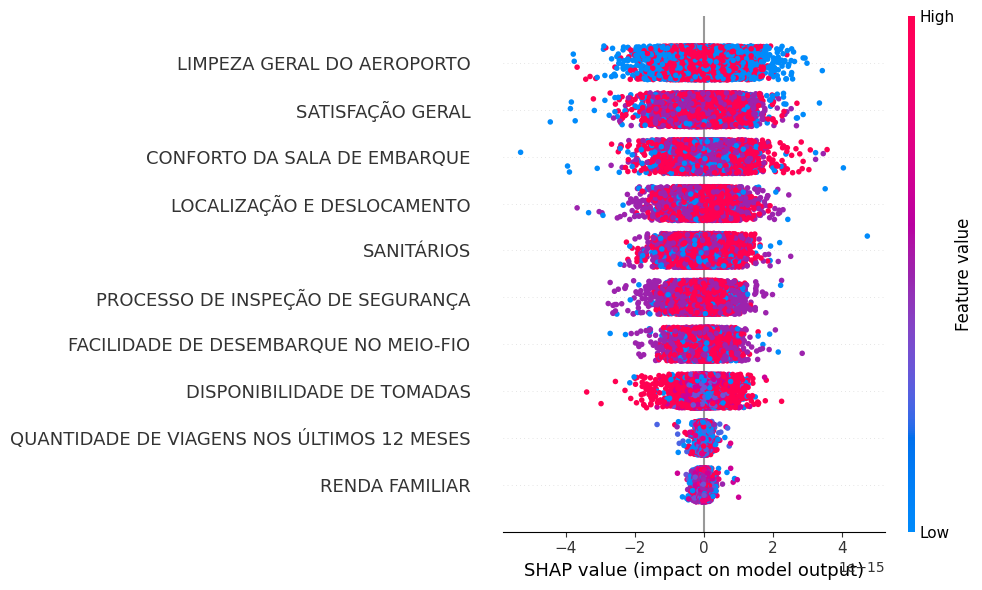

In [118]:
shap.summary_plot(shap_values_to_plot, X_test_am, feature_names=X_test_am.columns, max_display=10, plot_size=(10, 6))

##### Shap KMeans

In [119]:
rf_km = RandomForestClassifier(random_state=42)
rf_km.fit(X_train_km, y_train_km)

RandomForestClassifier(random_state=42)

In [ ]:
explainer_km = shap.TreeExplainer(rf_km)
shap_values_km = explainer_km.shap_values(X_test_km)

In [ ]:
shap_values_to_plot = np.mean(shap_values_km, axis=2)

In [ ]:
shap.summary_plot(shap_values_to_plot, X_test_km, feature_names=X_test_km.columns, max_display=10, plot_size=(10, 6))